## Preproccessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import pandas as pd 


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression

#### Load Data

In [2]:
feature = ['year' , 'puissance' , 'kilometrage' , 'type_boit' ,'type_carburant' , 'marke' , 'model' , 'price']
feature_seledted = ['year' , 'puissance' , 'kilometrage' , 'type_boit' ,'type_carburant' , 'marke' , 'model']

DataSet = pd.read_csv('./Data/CleanData.csv')
DataSet = DataSet[feature]


#### Preprocessing Pipeline

In [ ]:
def create_preprocessing_pipeline(df, target_col='price', test_size=0.2, random_state=42):
    """
    Fixed preprocessing pipeline with proper column handling
    """
    try:
        # Deep copy the DataFrame to prevent modifications
        df = df.copy()
        
        # Verify target column exists
        if target_col not in df.columns:
            raise ValueError(f"Target column '{target_col}' not found in DataFrame")
        
        # Separate features and target
        X = df.drop(columns=[target_col])
        y = df[target_col]
        
        print(f"Input shapes - X: {X.shape}, y: {y.shape}\n")
        
        # Create basic train-test split first
        X_train_basic, X_test_basic, y_train_basic, y_test_basic = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # Get selected features
        selected_features = feature_seledted
        
        if not selected_features:
            raise ValueError("No features were selected by the feature selector")
            
        print(f"\nSelected features: {selected_features}")
        
        # Filter DataFrames to only include selected features
        X_train_basic_selected = X_train_basic[selected_features]
        X_test_basic_selected = X_test_basic[selected_features]
        
        # Now create preprocessing pipeline for the selected features only
        transformers = []
        
        # Identify numerical and categorical columns among selected features
        num_attribs = [col for col in selected_features 
                      if X_train_basic[col].dtype in ['int64', 'float64']]
        cat_attribs = [col for col in selected_features 
                      if X_train_basic[col].dtype == 'object']
        
        if num_attribs:
            num_pipeline = make_pipeline(StandardScaler())
            transformers.append(('num', num_pipeline, num_attribs))
            
        if cat_attribs:
            cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
            transformers.append(('cat', cat_pipeline, cat_attribs))
            
        preprocessor = ColumnTransformer(transformers)
        
        # Try to create stratified split using most important feature
      
        result = {
            'basic_split': {
                'X_train': X_train_basic_selected,
                'X_test': X_test_basic_selected,
                'y_train': y_train_basic,
                'y_test': y_test_basic,
                'preprocessor': preprocessor
            },
            'selected_features': selected_features
        }
        
        return result
        
    except Exception as e:
        print(f"Preprocessing pipeline failed: {str(e)}")
        print("Error traceback:")
        import traceback
        traceback.print_exc()
        return None

#### Calculate various regression evaluation metrics

In [4]:


def Reg_Models_Evaluation_Metrics(model, X_train, y_train, X_test, y_test, y_pred):
    """
    Calculate various regression evaluation metrics
    
    Parameters:
    -----------
    model : estimator object
        The fitted model
    X_train : array-like
        Training data features
    y_train : array-like
        Training data target
    X_test : array-like
        Test data features
    y_test : array-like
        Test data target
    y_pred : array-like
        Predicted values
        
    Returns:
    --------
    tuple
        (R2, Adjusted R2, Cross-validated R2, RMSE)
    """
    # Calculate cross-validation score
    cv_score = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10)
    CV_R2 = cv_score.mean()
    
    # Calculate R-squared
    R2 = model.score(X_test, y_test)
    
    # Calculate Adjusted R-squared
    n = X_test.shape[0]  # Number of observations
    p = X_test.shape[1]  # Number of features
    adjusted_r2 = 1-(1-R2)*(n-1)/(n-p-1)
    
    # Calculate RMSE
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Print metrics
    print(f'RMSE: {RMSE:.4f}')
    print(f'R2: {R2:.4f}')
    print(f'Adjusted R2: {adjusted_r2:.4f}')
    print(f'Cross Validated R2: {CV_R2:.4f}')
    
    return R2, adjusted_r2, CV_R2, RMSE

#### Evaluate multiple base models using preprocessed data
 - Training multiple Models

In [5]:
def evaluate_base_models(preprocessed_data, strategy_name):
    """
    Evaluate multiple base models using preprocessed data
    """
    # Extract data and preprocessor
    X_train = preprocessed_data['X_train']
    y_train = preprocessed_data['y_train']
    X_test = preprocessed_data['X_test']
    y_test = preprocessed_data['y_test']
    preprocessor = preprocessed_data['preprocessor']
    
    print(f"\nEvaluating models for {strategy_name}")
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    
    # Transform the data using the preprocessor
    try:
        X_train_transformed = preprocessor.fit_transform(X_train)
        X_test_transformed = preprocessor.transform(X_test)
        
        print(f"Transformed training data shape: {X_train_transformed.shape}")
        print(f"Transformed test data shape: {X_test_transformed.shape}")
        
    except Exception as e:
        print(f"Error during data transformation: {str(e)}")
        raise
    
    # Convert to dense array if sparse
    if hasattr(X_train_transformed, "toarray"):
        X_train_transformed = X_train_transformed.toarray()
    if hasattr(X_test_transformed, "toarray"):
        X_test_transformed = X_test_transformed.toarray()
    
    # Initialize models
    models = {
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42),
        'Ridge': Ridge(random_state=42)
    }
    
    results = {}
    fitted_models = {}
    
    for name, model in models.items():
        try:
            print(f"\nFitting {name}...")
            model.fit(X_train_transformed, y_train)
            y_pred = model.predict(X_test_transformed)
            
            R2, adj_r2, cv_r2, rmse = Reg_Models_Evaluation_Metrics(
                model, X_train_transformed, y_train, X_test_transformed, y_test, y_pred
            )
            
            results[f"{strategy_name} - {name}"] = {
                'R2': R2,
                'Adjusted R2': adj_r2,
                'CV R2': cv_r2,
                'RMSE': rmse
            }
            fitted_models[name] = model
            
        except Exception as e:
            print(f"Error evaluating {name}: {str(e)}")
            continue
    
    return results, fitted_models

Input shapes - X: (58751, 7), y: (58751,)


Selected features: ['year', 'puissance', 'kilometrage', 'type_boit', 'type_carburant', 'marke', 'model']

Evaluating models for Basic Split
Training data shape: (47000, 7)
Test data shape: (11751, 7)
Transformed training data shape: (47000, 784)
Transformed test data shape: (11751, 784)

Fitting Decision Tree...
RMSE: 27175.0166
R2: 0.8794
Adjusted R2: 0.8707
Cross Validated R2: 0.8656

Fitting Random Forest...
RMSE: 23640.5882
R2: 0.9087
Adjusted R2: 0.9022
Cross Validated R2: 0.9031

Fitting XGBoost...
RMSE: 23845.5591
R2: 0.9071
Adjusted R2: 0.9005
Cross Validated R2: 0.9052

Fitting Ridge...
RMSE: 33333.3538
R2: 0.8185
Adjusted R2: 0.8055
Cross Validated R2: 0.8193
Creating the plots .....
Creating the plots .....
Creating the plots .....
Creating the plots .....
showing the plot...


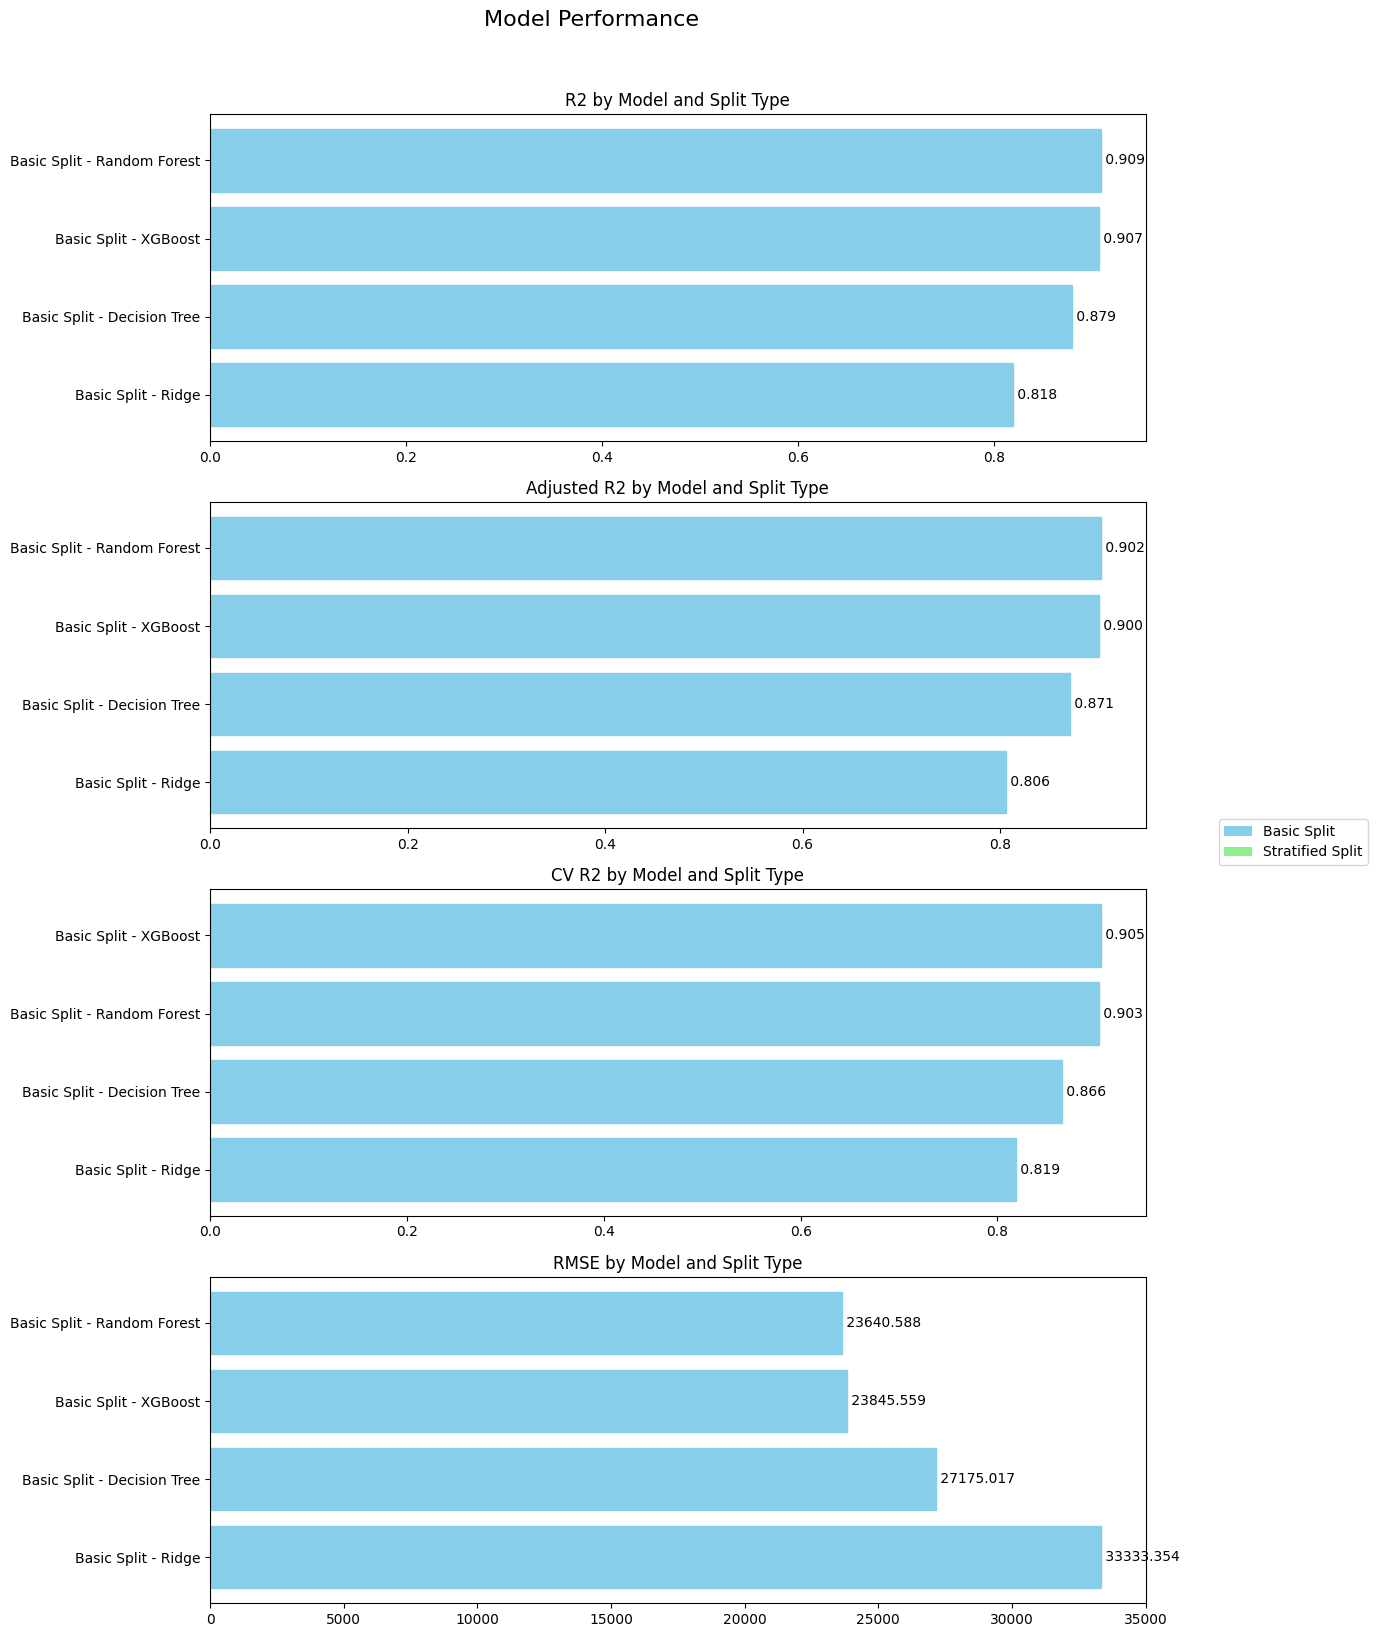

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_and_visualize_models(df, target_col='price'):
    # Create preprocessed data
    preprocessed_data = create_preprocessing_pipeline(df, target_col=target_col)
    
    all_results = {}
    
    try:
        # Evaluate models using both splits
        basic_results, basic_models = evaluate_base_models(
            preprocessed_data['basic_split'],
            'Basic Split'
        )
        
     
        all_results.update(basic_results)
        
        # Convert results to DataFrame for visualization
        results_df = pd.DataFrame.from_dict(all_results, orient='index')
        
        # Create plot
        metrics = ['R2', 'Adjusted R2', 'CV R2', 'RMSE']
        n_metrics = len(metrics)
        
        fig, axes = plt.subplots(n_metrics, 1, figsize=(12, 4*n_metrics))
        fig.suptitle('Model Performance ', fontsize=16, y=1.02)
        
        # Color palette for different split types
        colors = {'Basic Split': 'skyblue', 'Stratified Split': 'lightgreen'}
        
        for idx, metric in enumerate(metrics):
            print("Creating the plots .....")
            ax = axes[idx]
            
            # Sort results by metric value
            sort_ascending = False if metric == 'RMSE' else True
            plot_data = results_df[metric].sort_values(ascending=sort_ascending)
            
            # Create bars
            bars = ax.barh(range(len(plot_data)), plot_data.values)
            
            # Color bars based on split type
            for i, bar in enumerate(bars):
                split_type = plot_data.index[i].split(' - ')[0]
                bar.set_color(colors[split_type])
            
            # Customize plot
            ax.set_title(f'{metric} by Model and Split Type')
            ax.set_yticks(range(len(plot_data)))
            ax.set_yticklabels(plot_data.index)
            
            # Add value labels on bars
            for i, v in enumerate(plot_data.values):
                ax.text(v, i, f' {v:.3f}', va='center')
        
        # Adjust layout and add legend
        plt.tight_layout()
        
        # Create custom legend
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=split)
                         for split, color in colors.items()]
        fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.15, 0.5))
        
        # Show the plot
        print("showing the plot...")
        plt.show()
        
        return basic_models, preprocessed_data
        
    except Exception as e:
        print(f"Process failed: {str(e)}")
        return None, None

# Run the evaluation and visualization
basic_models, preprocessed_data = evaluate_and_visualize_models(DataSet, 'price')



### Save Preproccessing

In [7]:
preprocessor = preprocessed_data['basic_split']['preprocessor']

In [8]:
import joblib
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

#### Save Models

In [9]:
for name, model in basic_models.items():
    joblib.dump(model, f'{name.replace(" ", "_").lower()}_model.pkl')
    print(f"Model {name} saved as {name.replace(' ', '_').lower()}_model.pkl")

Model Decision Tree saved as decision_tree_model.pkl
Model Random Forest saved as random_forest_model.pkl
Model XGBoost saved as xgboost_model.pkl
Model Ridge saved as ridge_model.pkl
